甲状腺数据Autoencoder异常检测

1. 数据准备...
使用的特征数: 12
特征列表: ['TSH', 'T3_measured', 'TT4_measured', 'T4U_measured', 'FTI_measured', 'Age', 'on_thyroxine', 'query_hypothyroid', 'query_hyperthyroid', 'thyroid_surgery', 'I131_treatment', 'Sex']
训练集大小: (4841, 12), 测试集大小: (2075, 12)

2. 训练Autoencoder...
Epoch [10/100], Train Loss: 0.412031, Val Loss: 0.578804
Epoch [20/100], Train Loss: 0.336383, Val Loss: 0.491021
Epoch [30/100], Train Loss: 0.298063, Val Loss: 0.467682
Epoch [40/100], Train Loss: 0.285477, Val Loss: 0.451899
Epoch [50/100], Train Loss: 0.272116, Val Loss: 0.447932
Epoch [60/100], Train Loss: 0.268532, Val Loss: 0.429557
Epoch [70/100], Train Loss: 0.257243, Val Loss: 0.437513
Epoch [80/100], Train Loss: 0.245712, Val Loss: 0.437930
Epoch [90/100], Train Loss: 0.247101, Val Loss: 0.427445
Epoch [100/100], Train Loss: 0.250448, Val Loss: 0.430643


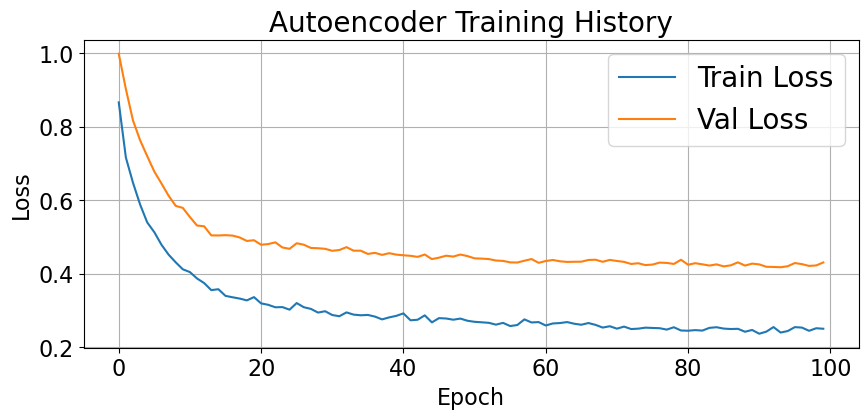


3. 异常检测...

4. 异常模式分析...
检测到 83 个异常样本
前20个最异常样本的索引: [1979 1829 1791  173 1365  838 1722 1351  757 1107 1936  569 1333  271
  644  409 1797 1548  457  402]

前20异常样本的关键特征统计:
             TSH  T3_measured  TT4_measured  T4U_measured  FTI_measured  \
count  20.000000     20.00000     20.000000     20.000000     20.000000   
mean    0.751513     11.65603     82.272500     91.404000    100.261500   
std     3.126328      9.03718     45.057721     25.768383     41.329013   
min     0.000400      0.02010      0.100000      0.080000      0.110000   
25%     0.000887      0.02010     76.500000     83.750000     89.750000   
50%     0.001650     13.00000    100.000000     95.500000    100.000000   
75%     0.002465     18.25000    105.250000    103.250000    117.250000   
max    14.000000     26.00000    151.000000    122.000000    158.000000   

       anomaly_score  
count      20.000000  
mean       31.785965  
std       128.372742  
min         2.088319  
25%         2.269070  
50%         2

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# 设置随机种子
np.random.seed(42)
torch.manual_seed(42)

class ThyroidAutoencoder(nn.Module):
    """专门为甲状腺数据设计的Autoencoder"""
    def __init__(self, input_dim, latent_dim=8):
        super(ThyroidAutoencoder, self).__init__()
        
        # 编码器
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Linear(16, latent_dim),
            nn.ReLU()
        )
        
        # 解码器
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
            # 注意：不添加激活函数，因为我们需要原始尺度的重构
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        """获取潜在表示"""
        return self.encoder(x)

def prepare_thyroid_data(df, features=None):
    """
    准备甲状腺数据用于Autoencoder
    """
    if features is None:
        # 选择关键特征（根据你的数据集调整）
        numeric_features = ['TSH', 'T3_measured', 'TT4_measured', 'T4U_measured', 'FTI_measured', 'Age']
        binary_features = ['on_thyroxine', 'query_hypothyroid', 'query_hyperthyroid', 
                          'thyroid_surgery', 'I131_treatment', 'Sex']
        
        # 确保特征存在
        available_numeric = [f for f in numeric_features if f in df.columns]
        available_binary = [f for f in binary_features if f in df.columns]
        features = available_numeric + available_binary
    
    print(f"使用的特征数: {len(features)}")
    print(f"特征列表: {features}")
    
    # 提取特征
    X = df[features].values
    
    # 标准化数值特征
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, scaler, features

def train_autoencoder(X_train, X_val, input_dim, epochs=100, batch_size=32, latent_dim=8):
    """
    训练Autoencoder
    """
    # 转换为PyTorch张量
    X_train_tensor = torch.FloatTensor(X_train)
    X_val_tensor = torch.FloatTensor(X_val)
    
    # 创建数据加载器
    train_dataset = torch.utils.data.TensorDataset(X_train_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # 初始化模型、损失函数和优化器
    model = ThyroidAutoencoder(input_dim, latent_dim=latent_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    
    # 学习率调度器
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
    
    # 训练历史
    train_losses = []
    val_losses = []
    
    # 训练循环
    for epoch in range(epochs):
        # 训练阶段
        model.train()
        train_loss = 0
        for batch in train_loader:
            inputs = batch[0]
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        
        # 验证阶段
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, X_val_tensor).item()
        
        # 记录损失
        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        
        # 调整学习率
        scheduler.step(val_loss)
        
        # 每10个epoch打印一次进度
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {val_loss:.6f}')
    
    # 绘制训练曲线
    plt.figure(figsize=(10, 4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Autoencoder Training History')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return model

def detect_anomalies_with_autoencoder(model, X_test, y_test=None, contamination=0.1):
    """
    使用Autoencoder检测异常
    """
    # 计算重构误差
    model.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X_test)
        reconstructed = model(X_tensor)
        
        # 计算每个样本的MSE
        mse_loss = torch.mean((X_tensor - reconstructed) ** 2, dim=1)
        anomaly_scores = mse_loss.numpy()
    
    # 根据contamination参数确定阈值
    threshold = np.percentile(anomaly_scores, 100 * (1 - contamination))
    
    # 预测标签
    predictions = (anomaly_scores > threshold).astype(int)
    
    # 如果有真实标签，评估性能
    if y_test is not None:
        from sklearn.metrics import classification_report, confusion_matrix
        
        accuracy = np.mean(predictions == y_test)
        precision = np.sum((predictions == 1) & (y_test == 1)) / np.sum(predictions == 1)
        recall = np.sum((predictions == 1) & (y_test == 1)) / np.sum(y_test == 1)
        
        print(f"Autoencoder异常检测性能:")
        print(f"  准确率: {accuracy:.4f}")
        print(f"  精确率: {precision:.4f}")
        print(f"  召回率: {recall:.4f}")
        print(f"  阈值: {threshold:.6f}")
        
        # 绘制重构误差分布
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.hist(anomaly_scores[y_test == 0], bins=50, alpha=0.7, label='Normal', density=True)
        plt.hist(anomaly_scores[y_test == 1], bins=50, alpha=0.7, label='Outlier', density=True)
        plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold={threshold:.4f}')
        plt.xlabel('Reconstruction Error')
        plt.ylabel('Density')
        plt.title('重构误差分布')
        plt.legend()
        
        # 绘制ROC曲线
        plt.subplot(1, 2, 2)
        fpr, tpr, _ = roc_curve(y_test, anomaly_scores)
        roc_auc = roc_auc_score(y_test, anomaly_scores)
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC曲线')
        plt.legend(loc="lower right")
        
        plt.tight_layout()
        plt.show()
        
        # 打印分类报告
        print("\n分类报告:")
        print(classification_report(y_test, predictions, target_names=['Normal', 'Outlier']))
        
        # 混淆矩阵
        cm = confusion_matrix(y_test, predictions)
        print("混淆矩阵:")
        print(cm)
    
    return anomaly_scores, predictions, threshold

def analyze_anomaly_patterns(df, anomaly_scores, threshold, top_k=20):
    """
    分析检测到的异常样本模式
    """
    # 获取高异常分数的样本
    high_anomaly_idx = np.where(anomaly_scores > threshold)[0]
    
    if len(high_anomaly_idx) == 0:
        print("未检测到异常样本")
        return
    
    # 获取前top_k个最异常的样本
    top_indices = np.argsort(-anomaly_scores)[:top_k]
    
    print(f"检测到 {len(high_anomaly_idx)} 个异常样本")
    print(f"前{top_k}个最异常样本的索引: {top_indices}")
    
    # 分析这些样本的特征
    top_samples = df.iloc[top_indices].copy()
    top_samples['anomaly_score'] = anomaly_scores[top_indices]
    
    # 如果有Outlier_label，检查一致性
    if 'Outlier_label' in df.columns:
        top_samples['true_label'] = df.iloc[top_indices]['Outlier_label'].values
        agreement = np.mean(top_samples['true_label'] == 1)
        print(f"前{top_k}异常样本与真实标签的一致性: {agreement:.2%}")
    
    # 显示关键特征的统计
    key_features = ['TSH', 'T3_measured', 'TT4_measured', 'T4U_measured', 'FTI_measured']
    available_features = [f for f in key_features if f in df.columns]
    
    print(f"\n前{top_k}异常样本的关键特征统计:")
    print(top_samples[available_features + ['anomaly_score']].describe())
    
    # 识别常见异常模式
    print(f"\n常见异常模式分析:")
    
    # 模式1: TSH极端值
    tsh_extreme = top_samples[(top_samples['TSH'] > 50) | (top_samples['TSH'] < 0.1)]
    if len(tsh_extreme) > 0:
        print(f"  1. TSH极端值模式: {len(tsh_extreme)} 个样本")
    
    # 模式2: 甲状腺指标矛盾
    if 'TSH' in df.columns and 'TT4_measured' in df.columns:
        # TSH高但T4不低，或TSH低但T4不高
        contradiction_mask = (
            (top_samples['TSH'] > 10) & (top_samples['TT4_measured'] > top_samples['TT4_measured'].median()) |
            (top_samples['TSH'] < 0.1) & (top_samples['TT4_measured'] < top_samples['TT4_measured'].median())
        )
        contradiction_samples = top_samples[contradiction_mask]
        if len(contradiction_samples) > 0:
            print(f"  2. TSH-TT4矛盾模式: {len(contradiction_samples)} 个样本")
    
    # 模式3: FTI不一致（如果可计算）
    if all(f in df.columns for f in ['TT4_measured', 'T4U_measured', 'FTI_measured']):
        # 注意：需要根据T4U的实际单位调整
        # 假设T4U是百分比形式，需要除以100
        calculated_fti = top_samples['TT4_measured'] * (top_samples['T4U_measured'] / 100)
        fti_discrepancy = np.abs(top_samples['FTI_measured'] - calculated_fti) / (calculated_fti + 1e-10)
        fti_inconsistent = top_samples[fti_discrepancy > 0.3]
        if len(fti_inconsistent) > 0:
            print(f"  3. FTI不一致模式: {len(fti_inconsistent)} 个样本")
    
    return top_samples

def main_autoencoder_analysis(df, contamination=0.1):
    """
    主函数：使用Autoencoder进行异常检测
    """
    print("=" * 60)
    print("甲状腺数据Autoencoder异常检测")
    print("=" * 60)
    
    # 1. 准备数据
    print("\n1. 数据准备...")
    X, scaler, features = prepare_thyroid_data(df)
    
    # 如果有标签，分割数据
    if 'Outlier_label' in df.columns:
        y = df['Outlier_label'].values
        
        # 为了无监督学习，我们使用所有数据训练
        # 但为了评估，我们保留一部分有标签的数据
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )
        
        # 注意：训练时不应该使用标签！
        print(f"训练集大小: {X_train.shape}, 测试集大小: {X_test.shape}")
    else:
        # 如果没有标签，使用全部数据
        X_train, X_test = train_test_split(X, test_size=0.3, random_state=42)
        y_test = None
        print(f"训练集大小: {X_train.shape}, 测试集大小: {X_test.shape}")
    
    # 2. 训练Autoencoder
    print("\n2. 训练Autoencoder...")
    input_dim = X_train.shape[1]
    model = train_autoencoder(
        X_train, 
        X_test, 
        input_dim=input_dim,
        epochs=100,
        batch_size=64,
        latent_dim=min(8, input_dim // 2)  # 潜在维度为输入维度的一半
    )
    
    # 3. 异常检测
    print("\n3. 异常检测...")
    anomaly_scores, predictions, threshold = detect_anomalies_with_autoencoder(
        model, X_test, y_test, contamination=contamination
    )
    
    # 4. 分析异常模式
    print("\n4. 异常模式分析...")
    top_samples = analyze_anomaly_patterns(df, anomaly_scores, threshold, top_k=20)
    
    # 5. 将异常分数添加到原始数据框
    df_result = df.copy()
    # 注意：异常分数只对测试集有效
    test_indices = df.index[-len(anomaly_scores):] if len(anomaly_scores) < len(df) else df.index
    df_result.loc[test_indices, 'autoencoder_anomaly_score'] = 0
    df_result.loc[test_indices, 'autoencoder_anomaly_score'] = anomaly_scores
    
    # 标记异常
    df_result.loc[test_indices, 'autoencoder_prediction'] = 0
    df_result.loc[test_indices, 'autoencoder_prediction'] = predictions
    
    print("\n5. 完成!")
    print(f"总样本数: {len(df_result)}")
    print(f"预测异常数: {predictions.sum()}")
    if 'Outlier_label' in df_result.columns:
        print(f"实际异常数: {df_result['Outlier_label'].sum()}")
    
    return df_result, model, anomaly_scores, threshold

# 使用示例
if __name__ == "__main__":
    # 假设你的数据框是df_final
    df_result, model, anomaly_scores, threshold = main_autoencoder_analysis(X, contamination=0.04)
    
    # 或者，如果你没有真实标签
    # df_result, model, anomaly_scores, threshold = main_autoencoder_analysis(df_final, contamination=0.1)
    
    print("请将你的数据框传入main_autoencoder_analysis函数")

0.7015665531158445


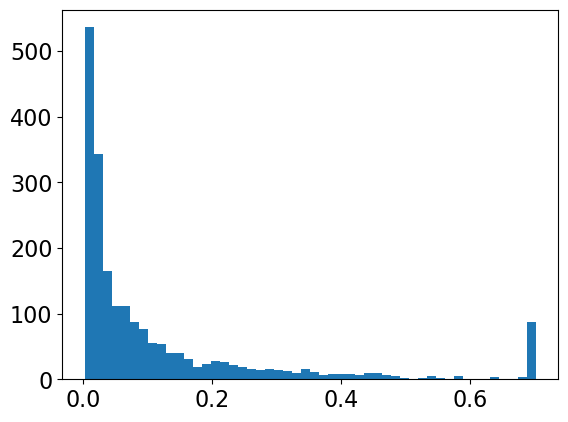

In [ ]:
# df_result, model, anomaly_scores, threshold
plt.hist(anomaly_scores.clip(max=threshold), bins=50)
print(threshold)
idx = np.where(anomaly_scores > threshold)[0]
X_anomalies = df_final.iloc[idx]
precision = np.mean(y.iloc[idx])
print(f"Detected {len(idx)} anomalies with precision {precision:.4f}")